# The dataset we use can be found on the Kaggle website
### https://www.kaggle.com/c/store-sales-time-series-forecasting/data

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [173]:
data = pd.read_csv("train.csv")
data.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Splitting the Date Column
### The `date` column is composed of three components: year, month, and day. To facilitate time-based analysis, we split this column into separate `year`, `month`, and `day` columns, and convert each of them to integers.

In [174]:

data[['year', 'month', 'day']] = data['date'].str.split('-', expand=True).astype(int)
data.head(5)

,id,date,store_nbr,family,sales,onpromotion,year,month,day
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1


In [175]:
sales = data['sales']

# Exploratory Data Analysis

In [176]:
print(data.isnull().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month          0
day            0
dtype: int64


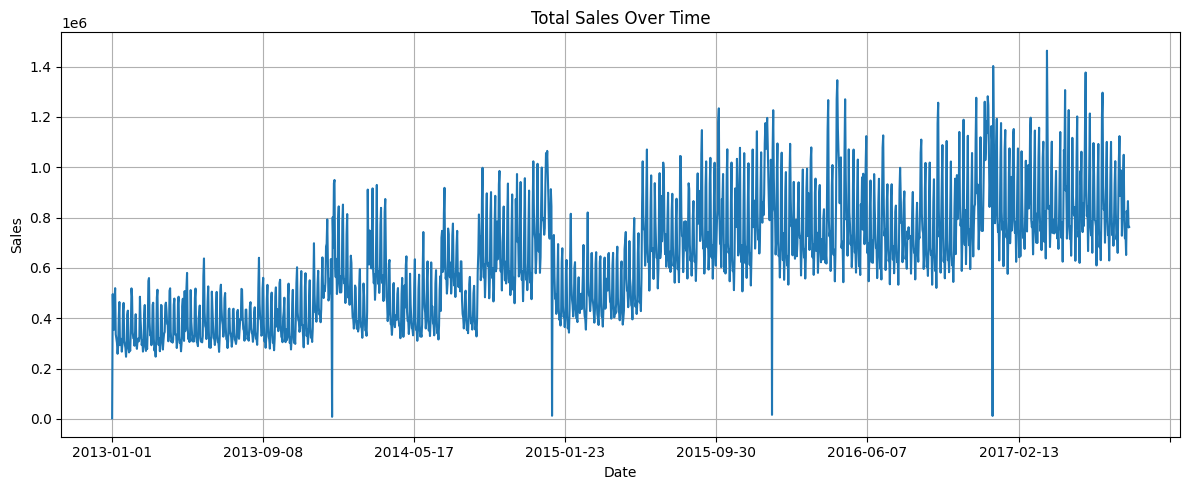

In [177]:
plt.figure(figsize=(12, 5))
data.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Sales Over Time

- A clear upward trend in sales over the years, indicating business growth.
- Recurring seasonal patterns, likely linked to holidays and promotional events.
- Several sharp drops in sales, which may correspond to holidays when stores were closed or data gaps.

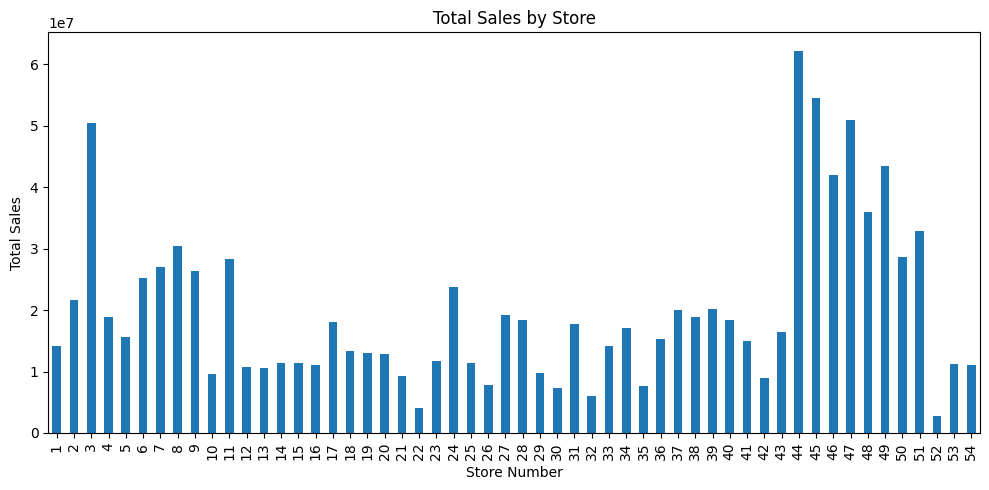

In [178]:
store_sales = data.groupby('store_nbr')['sales'].sum().sort_index()

plt.figure(figsize=(10, 5))
store_sales.plot(kind='bar')
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

## Total Sales by Store

#### This bar chart displays the total sales for each store over the entire time period.

- Store 44, 45, and 47 show the highest overall sales, indicating they are likely high-traffic or high-performing locations.
- There is considerable variation in total sales between stores, suggesting differences in location size, customer base, or product availability.
- Some stores, such as Store 22 and Store 52, have noticeably lower sales volumes.

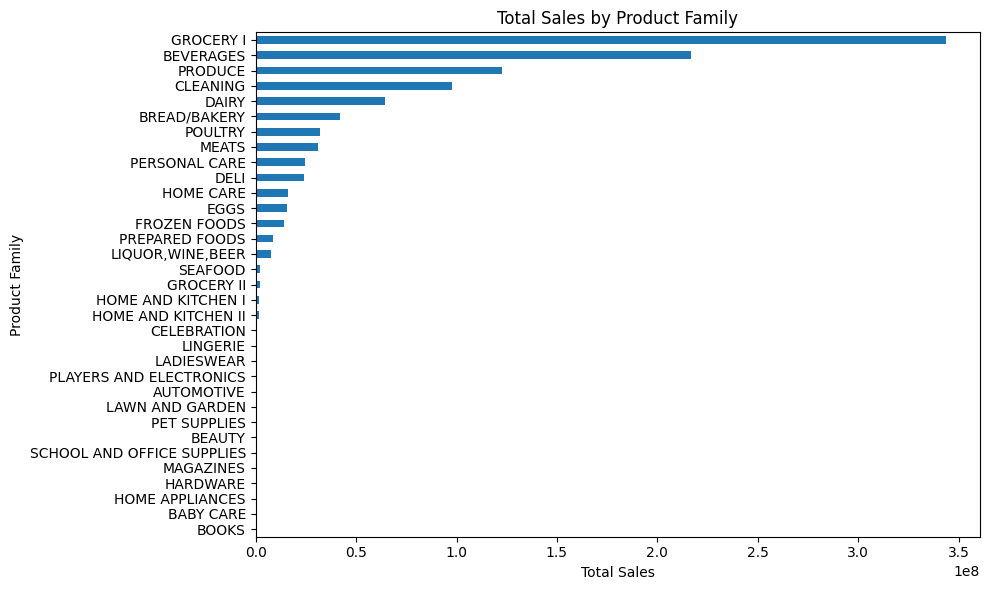

In [179]:
family_sales = data.groupby('family')['sales'].sum().sort_values()

plt.figure(figsize=(10, 6))
family_sales.plot(kind='barh')
plt.title('Total Sales by Product Family')
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.tight_layout()
plt.show()

## Total Sales by Product Family

#### This horizontal bar chart shows the total sales for each product family across all stores and dates.

Key insights:
- GROCERY I and BEVERAGES are the top-selling categories by a large margin, suggesting they are core drivers of revenue.
- Categories like BOOKS, BABY CARE, and HOME APPLIANCES generate significantly lower sales.